In [1]:
# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback

# EDA and Data Wrangling
import matplotlib.pyplot as plt
import numpy as np

# Kaggle
#from kaggle_datasets import KaggleDatasets

# Submission
import shutil
import os
import PIL


AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
# Profiling
# Stop the previous profiler if it's running
try:
    tf.profiler.experimental.stop()
except tf.errors.UnavailableError:
    # Profiler wasn't running
    pass
tf.profiler.experimental.start('logdir')
print("Profiler started.")

Profiler started.



#             Makin' That Monet


This Notebook is designed to explore the creation of a GAN, or Generative Adversarial Network. To illustrate the journey and concepts of this topic I will be using the assignments challenge 'I'm something of a painter myself" Kaggle competition, linked below. In the challenge contestants are...

"...*generate images in the style of Monet. This generator is trained using a discriminator.*

*The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.*

*Your task is to build a GAN that generates 7,000 to 10,000 Monet-style images.
"*


Data Description

The dataset in the Kaggle competition consists of two sets of images:

Monet Paintings: Images of Claude Monet's paintings, representing the target artistic style.
Photos: Real-world photographs that will be transformed into the Monet style.
Data Size and Structure:

Number of Photo Images: 300
Photo Image Dimensions: 256x256
PhotoImage Format: TFRecord format

Number of Paintings: 300
Painting Image Dimensions: 256x256
Painting Image Format: TFRecord format


## References

This notebook was created with assistance by the recomended notebook listed in the competition, found here:
https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial

Other resources include:
Structuring
https://www.kaggle.com/code/chongzhenjie/photo-to-monet-cyclegan-pytorch-lightning#2.-Building-CycleGAN-Architecture

Cycle Gan Generator Architecture:
https://www.tensorflow.org/tutorials/generative/dcgan
https://discuss.ai.google.dev/t/a-concatenate-layer-requires-inputs-with-matching-shapes-except-for-the-concatenation-axis-received-input-shape-none-7-7-512-none-2/32685
https://datascience.stackexchange.com/questions/26942/concat-mode-can-only-merge-layers-with-matching-output-shapes-except-for-the-c

Keras CycleGAN general Information
https://keras.io/examples/generative/cyclegan/

Training help
https://www.kaggle.com/code/hidetaketakahashi/monet-cyclegan-resnet#4.-Training-

Distributed Training
https://keras.io/guides/distribution/

In [3]:
# After researching methods on improving quality of image generation I found the
# Reflection Padding 2D
class ReflectionPadding2D(layers.Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.pad(inputs, [[0, 0], [self.padding[0], self.padding[0]], [self.padding[1], self.padding[1]], [0, 0]], 'REFLECT')

# Data Loading

Once again I have to thank Kaggle for making such an amazing place for practicing such a complex task like deep learning.

We'll load in their nice dataset using the Glob library. We'll verify the number of files as an extra measure verifying we have the right data according to the parameters shared on the datacard webpage.

In [4]:
# Data PAth
GCS_PATH = "/content/drive/MyDrive/Academia/MSDS/Machine Learning Specialization/DTSA5511 Deep Learning/Monet_files"

In [5]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


## Helper Methods

Here we establish a couple simple helper methods to make our lives simpler. First we need one that laods in the image. At the suggestion of the competition creators we're going to load in the TFRecord files. To start we make a 3 column dataframe and bring in the images. Then we decode them and perform a little bit of manipulation (normalization and reshaping).

In [6]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [7]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

# EDA & Data Sample
First Im making two versions of the dataset; one is for training and one is for validation. The reason for this is because there is only 300 images and so we want to augment training. We do this by allowing it to repeat and shuffiling it in the process.

Now let's take a look at a couple images from both datsets:

In [8]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1).repeat().shuffle(buffer_size=1000)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1).repeat().shuffle(buffer_size=1000)
# Above for Training, below for submission
monet_ds_sub = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds_sub = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [9]:
example_monet_1, example_monet_2 = next(iter(monet_ds)), next(iter(monet_ds))
example_photo_1, example_photo_2 = next(iter(photo_ds)), next(iter(photo_ds))


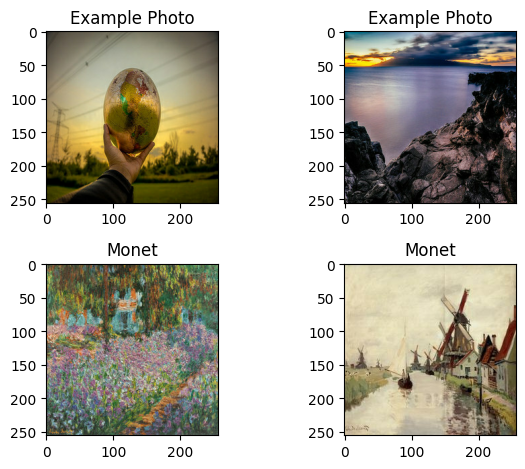

In [10]:
fig, axes = plt.subplots(2, 2)

axes[0, 0].imshow(example_photo_1[0] * 0.5 + 0.5)
axes[0, 0].set_title('Example Photo')

axes[0, 1].imshow(example_photo_2[0] * 0.5 + 0.5)
axes[0, 1].set_title('Example Photo')

axes[1, 0].imshow(example_monet_1[0] * 0.5 + 0.5)
axes[1, 0].set_title('Monet')

axes[1, 1].imshow(example_monet_2[0] * 0.5 + 0.5)
axes[1, 1].set_title('Monet')

plt.tight_layout() # Improves subplot spacing
plt.show()

Next let's take a quick check. Given the parameters of the Kaggle challenge we are fairly confident in clean data. However it's always worth it to be sure!
First we will do a quick scan for corrupted or error files in our pictures. Then we will move on to examining the spread in our pizel values R G and B. Any extreme outliers (All black or All white) could indicate faulty files.

In [11]:


def check_for_errors(dataset, dataset_name):
    error_files = []
    for i, image in enumerate(dataset):
        try:
            # Attempt to display the image. If an error occurs, it's likely a corrupted file.
            plt.imshow(image[0] * 0.5 + 0.5)

        except Exception as e:
            print(f"Error processing image {i} in {dataset_name}: {e}")
            error_files.append(i)  # Store the index of the problematic image

    return error_files

def check_for_black_white(dataset, dataset_name):
    black_white_images = []
    for i, image in enumerate(dataset):
        # Check for all-black or all-white images
        img_array = (image[0].numpy() * 0.5 + 0.5) * 255
        is_black = np.all(img_array == 0)
        is_white = np.all(img_array == 255)
        if is_black or is_white:
            black_white_images.append(i)
            print(f"Image {i} in {dataset_name} is {'black' if is_black else 'white'}")

    return black_white_images

# Check for errors / All Black or White in the submission datasets
#photo_errors = check_for_errors(photo_ds_sub, "photo_ds_sub")
#monet_errors = check_for_errors(monet_ds_sub, "monet_ds_sub")
photo_bw = check_for_black_white(photo_ds_sub, "photo_ds_sub")
monet_bw = check_for_black_white(monet_ds_sub, "monet_ds_sub")


In [12]:

#print("\nError Files:")
#if photo_errors:
#  print(f"photo_ds_sub: {photo_errors}")
#else:
#  print(f"photo_ds_sub: No errors found.")

#if monet_errors:
#  print(f"monet_ds_sub: {monet_errors}")
#else:
#  print(f"monet_ds_sub: No errors found.")


print("\nBlack or White Images:")
if photo_bw:
    print(f"photo_ds_sub: Indices of black or white images - {photo_bw}")
else:
    print(f"photo_ds_sub: No black or white images found.")

if monet_bw:
    print(f"monet_ds_sub: Indices of black or white images - {monet_bw}")
else:
    print(f"monet_ds_sub: No black or white images found.")




Black or White Images:
photo_ds_sub: No black or white images found.
monet_ds_sub: No black or white images found.


# Model plan and Architecture

Generator Architecture Outline

Input: The generator takes an image as input with the shape [256, 256, 3].
Downsampling Path:
Several downsample blocks are applied sequentially to reduce the spatial dimensions of the input. Each downsample block consists of a convolution, batch normalization, and a LeakyReLU activation.
Skip connections are created by storing the output of each downsample block in a list called skips.

Bottleneck:

The downsampling path ends with the input being reduced to a low spatial resolution.

Upsampling Path:

Several upsample blocks are applied to increase the spatial dimensions back to the original input size. Each upsample block consists of a transposed convolution, batch normalization, and either a LeakyReLU activation or a LeakyReLU activation with dropout.
Skip connections from the downsampling path are incorporated using concatenation with the corresponding upsampled feature maps.

Output:

A final transposed convolution is used to generate the output image with the desired shape [256, 256, 3]. A tanh activation is applied to the output.

In [13]:
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    #gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(layers.BatchNormalization())

    result.add(layers.LeakyReLU(alpha=0.2))

    return result

parameter tuning note.... changed from relu to leakyrelu

In [14]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    #gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    #result.add(layers.Conv2D(filters, (3, 3), padding='same', activation='relu'))  # Added Conv2D layer
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(layers.BatchNormalization())

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.LeakyReLU(alpha=0.2))

    return result

In [15]:
def residual_block(x, filters):
       shortcut = x
       x = layers.Conv2D(filters, 3, padding='same')(x)
       x = layers.BatchNormalization()(x)
       x = layers.ReLU()(x)
       x = layers.Conv2D(filters, 3, padding='same')(x)
       x = layers.BatchNormalization()(x)
       x = layers.Add()([x, shortcut])
       x = layers.ReLU()(x)
       return x

In [16]:
def Generator():
    inputs = layers.Input(shape=[256, 256, 3])
    skips = []

    # Downsampling path
    x = downsample(64, 4, apply_instancenorm=False)(inputs)  # (bs, 128, 128, 64)
    skips.append(x)
    #x = residual_block(x, 64)
    x = downsample(128, 4)(x)  # (bs, 64, 64, 128)
    skips.append(x)
    #x = residual_block(x, 128)
    x = downsample(256, 4)(x)  # (bs, 32, 32, 256)
    skips.append(x)
    x = downsample(512, 4)(x)  # (bs, 16, 16, 512)
    skips.append(x)
    x = downsample(512, 4)(x)  # (bs, 8, 8, 512)
    x = downsample(512, 4)(x)  # (bs, 4, 4, 512)
    x = downsample(512, 4)(x)  # (bs, 2, 2, 512)
    x = downsample(512, 4)(x)  # (bs, 1, 1, 512)
    print("x = ", x.shape, "  Skips = ", skips)

    # Upsampling path and skip connections
    x = upsample(512, 4, apply_dropout=True)(x)  # (bs, 2, 2, 512)
    #x = residual_block(x, 512)
    x = upsample(512, 4, apply_dropout=True)(x)  # (bs, 4, 4, 1024)
    #x = residual_block(x, 512)
    x = upsample(512, 4, apply_dropout=True)(x)  # (bs, 8, 8, 1024)
    x = upsample(512, 4)(x)  # (bs, 16, 16, 1024)
    x = layers.Concatenate()([x, skips[-1]])  # Concatenate with the last skip connection
    x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    x = upsample(256, 4)(x)  # (bs, 32, 32, 512)
    x = layers.Concatenate()([x, skips[-2]])  # Concatenate with the fifth-to-last skip connection
    #x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = upsample(128, 4)(x)  # (bs, 64, 64, 256)
    x = layers.Concatenate()([x, skips[-3]])  # Concatenate with the sixth-to-last skip connection
    x = upsample(64, 4)(x)  # (bs, 128, 128, 128)

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4,
                                   strides=2,
                                   padding='same',
                                   kernel_initializer=initializer,
                                   activation='tanh')  # (bs, 256, 256, 3)

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [17]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    #gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)


    # Reflection padding and spectral normalization
    x = ReflectionPadding2D(padding=(1,1))(x)
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(x)

    # ... (instance normalization, LeakyReLU, final convolution) ...
    norm1 = layers.BatchNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(norm1)
    #dropout = layers.Dropout(0.2)(leaky_relu)
    last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(leaky_relu) #
    # ... (final convolution) ...


    return tf.keras.Model(inputs=inp, outputs=last)

# Establish a method for distributing work across hardware

https://keras.io/guides/distribution/

The next important part of preparing our framework is leveraging Keras's Distribution library. This is an established toolset fr distributing the training work across the hardware available. This is perfect as I had to utilize my own computer as well as Kaggle.

In [18]:
strategy = tf.distribute.MirroredStrategy()

# Print the number of devices (GPUs) available
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))


Number of devices: 1


In [19]:
with strategy.scope():
  monet_generator = Generator() # photos to Monet
  photo_generator = Generator() #  Monet to photos

  monet_discriminator = Discriminator() # differentiates Monet and generated Monet
  photo_discriminator = Discriminator() # differentiates real photos and generated photos

x =  (None, 1, 1, 512)   Skips =  [<KerasTensor shape=(None, 128, 128, 64), dtype=float32, sparse=False, name=keras_tensor_4>, <KerasTensor shape=(None, 64, 64, 128), dtype=float32, sparse=False, name=keras_tensor_9>, <KerasTensor shape=(None, 32, 32, 256), dtype=float32, sparse=False, name=keras_tensor_14>, <KerasTensor shape=(None, 16, 16, 512), dtype=float32, sparse=False, name=keras_tensor_19>]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


x =  (None, 1, 1, 512)   Skips =  [<KerasTensor shape=(None, 128, 128, 64), dtype=float32, sparse=False, name=keras_tensor_87>, <KerasTensor shape=(None, 64, 64, 128), dtype=float32, sparse=False, name=keras_tensor_92>, <KerasTensor shape=(None, 32, 32, 256), dtype=float32, sparse=False, name=keras_tensor_97>, <KerasTensor shape=(None, 16, 16, 512), dtype=float32, sparse=False, name=keras_tensor_102>]


# Create CycleGan Class

Here we slap together all of our functions and build out CycleGan Model. This was a pretty standard blueprint from what Keras suggests using, and their method of construction is nice and simple. With the level of complexity with this task I decided my main focus should be on the upsampling, downsampling, and generator tuning.

Next I used Keras Utilities to print out a visualization of the layer (SO HANDY)

In [20]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle

    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    # Define the call method to specify the forward pass
    def call(self, inputs, training=None):
        real_monet, real_photo = inputs

        # Generate fake images
        fake_monet = self.m_gen(real_photo, training=training)
        fake_photo = self.p_gen(real_monet, training=training)

        return fake_monet, fake_photo # Return the generated images


    def train_step(self, batch_data):
      real_monet, real_photo = batch_data

      with tf.GradientTape(persistent=True) as tape:
          # Forward pass
          fake_monet = self.m_gen(real_photo, training=True)
          fake_photo = self.p_gen(real_monet, training=True)
          cycled_monet = self.m_gen(fake_photo, training=True)
          cycled_photo = self.p_gen(fake_monet, training=True)
          same_monet = self.m_gen(real_monet, training=True)
          same_photo = self.p_gen(real_photo, training=True)

          # Discriminator loss
          disc_real_monet = self.m_disc(real_monet, training=True)
          disc_real_photo = self.p_disc(real_photo, training=True)
          disc_fake_monet = self.m_disc(fake_monet, training=True)
          disc_fake_photo = self.p_disc(fake_photo, training=True)
          monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
          photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

          # Generator loss
          monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
          photo_gen_loss = self.gen_loss_fn(disc_fake_photo)
          total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
          total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
          total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

      # Calculate gradients and update weights
      monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
      photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
      monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
      photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

      self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
      self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
      self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
      self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))

      return {
          "monet_gen_loss": total_monet_gen_loss,
          "photo_gen_loss": total_photo_gen_loss,
          "monet_disc_loss": monet_disc_loss,
          "photo_disc_loss": photo_disc_loss
      }

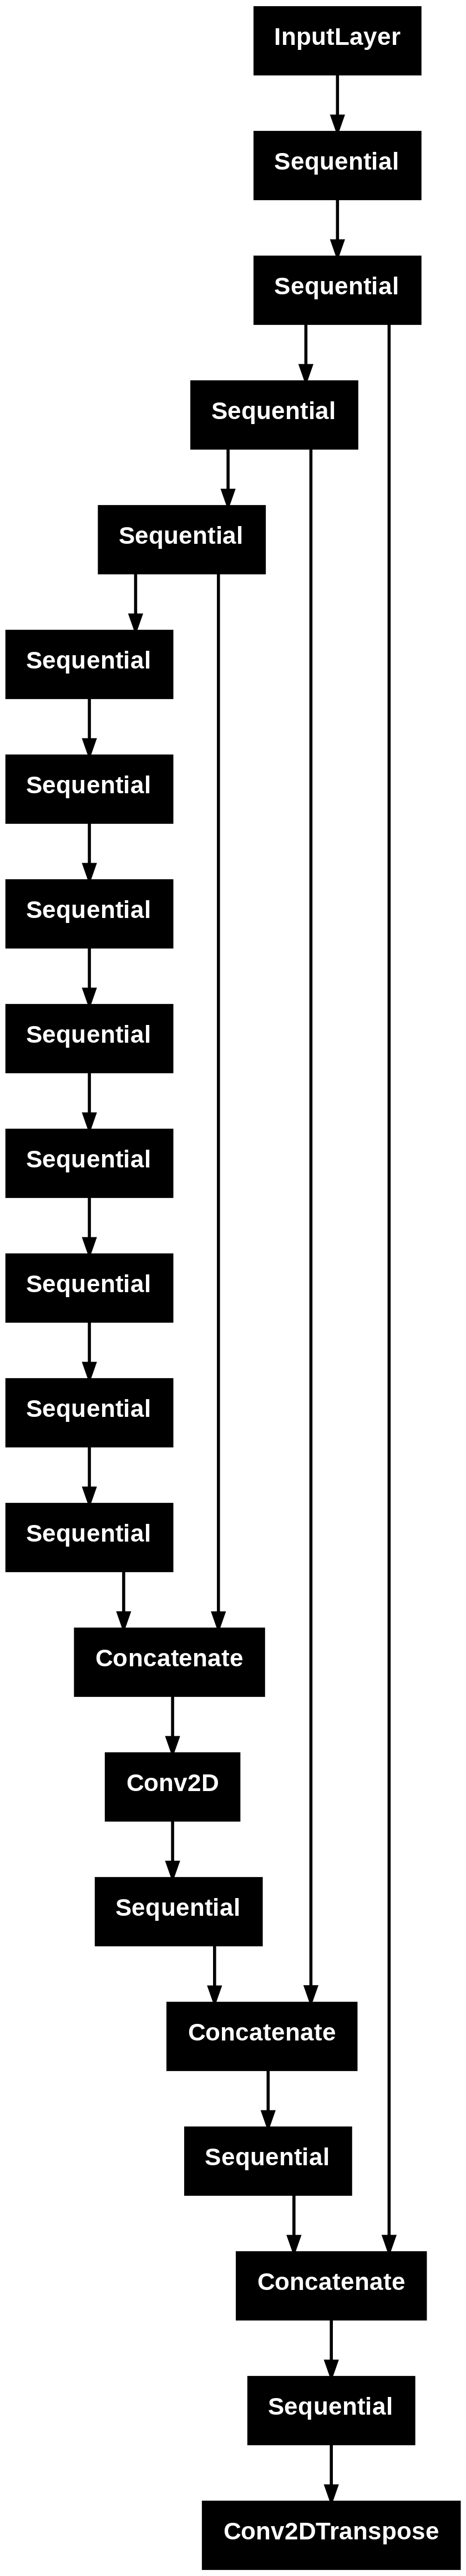

In [21]:
# Graph the blueprint of the Generator()
!pip install pydot
#with strategy.scope():  # Access monet_generator within the scope
tf.keras.utils.plot_model(monet_generator)

# Establish Loss Functions

The adversarial loss encourages the generator to create realistic images that can fool the discriminator. The cycle consistency loss ensures that the generated images can be translated back to the original domain, maintaining a cycle between the two domains.

In [22]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return tf.reduce_mean(total_disc_loss) * 0.5

In [23]:
with strategy.scope():
    def generator_loss(generated):
        return tf.reduce_mean(tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated))

In [24]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [25]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

# Loss History Callback
 We set up our History Class so that we can leverage built in Keras functions to hyperparameter tune.


In [26]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('monet_gen_loss'))

# TRAINING

For training I descided to try and see if we could use Tensorflows Mirror Strategy to leverage the multiple GPU's in google and Kaggle.

* Use tf.distribute.MirroredStrategy for potential multi-GPU training.

After I call the compiler for the cyclegan. I trial it on two example photos to ensure our processes and helped folders get created successfully.

* Compile the CycleGan model with Adam optimizers.

Train the model using the dataset and defined loss functions.

Use a learning rate scheduler (ReduceLROnPlateau) to adjust the learning rate during training.

In [27]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [28]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [29]:
_ = cycle_gan_model([example_monet_1, example_photo_1])

In [30]:
#Fit Callback Helpers

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='monet_gen_loss',
    factor=.8,
    patience=3,                # Wait
    min_lr=1e-6                # Minimum learning rate
)

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='monet_gen_loss',  # Metric
    patience=10,                # N epochs with no improvement
    restore_best_weights=True,  # Restore model weights
    mode='min',
    min_delta=0.00005
)

history = LossHistory()

In [31]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=30,
    steps_per_epoch=300,
    callbacks=[lr_scheduler, history]
)
# lr_scheduler, early_stopping

Epoch 1/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 92s 171ms/step - monet_disc_loss: 0.6898 - monet_gen_loss: 7.2833 - photo_disc_loss: 0.6913 - photo_gen_loss: 7.4574 - learning_rate: 0.0010
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 53s 178ms/step - monet_disc_loss: 0.6894 - monet_gen_loss: 5.9906 - photo_disc_loss: 0.6832 - photo_gen_loss: 6.0980 - learning_rate: 0.0010
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 54s 180ms/step - monet_disc_loss: 0.6874 - monet_gen_loss: 5.2226 - photo_disc_loss: 0.6844 - photo_gen_loss: 5.3151 - learning_rate: 0.0010
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 52s 172ms/step - monet_disc_loss: 0.6913 - monet_gen_loss: 4.8056 - photo_disc_loss: 0.6814 - photo_gen_loss: 4.8965 - learning_rate: 0.0010
Epoch 5/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 53s 178ms/step - monet_disc_loss: 0.6904 - monet_gen_loss: 4.5587 - photo_disc_loss: 0.6758 - photo_gen_loss: 4.6451 - learning_rate: 0.0010
Epoch 6/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 54s 179ms/step - monet_disc_loss: 0.6891 - monet_gen_lo

In [32]:
cycle_gan_model.save('/content/drive/MyDrive/Academia/MSDS/Machine Learning Specialization/DTSA5511 Deep Learning/cycle_gan_model.keras')

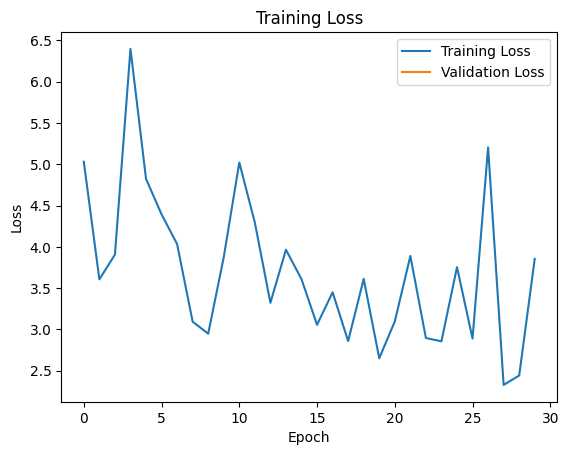

In [33]:
plt.plot(history.losses, label='Training Loss')
plt.plot(history.val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [34]:
#tf.keras.models.load_model('/content/drive/MyDrive/Academia/MSDS/Machine Learning Specialization/DTSA5511 Deep Learning/cycle_gan_model.keras')

In [35]:
import PIL
drive_path = '/content/drive/My Drive/images.zip'  # Replace with your desired path

0


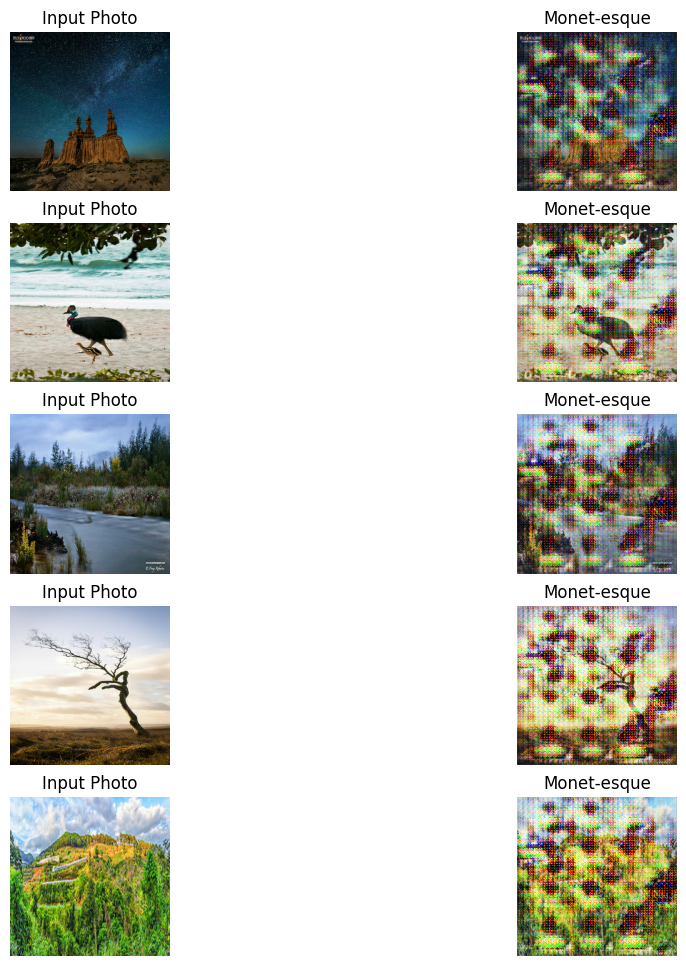

'/content/drive/My Drive/images.zip'

In [36]:
# For Local Machine
os.makedirs('images', exist_ok=True)
_, ax = plt.subplots(5, 2, figsize=(12, 12))
i = 1
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    if i % 1000 == 0:
        print(i)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()
shutil.make_archive("images", 'zip', "images")  # Create 'images.zip'
shutil.move("images.zip", "/content/drive/My Drive/images.zip")  # Move to Google Drive

# Results and Conclusion

This was A crazy and interesting experience. Tuning a psychogan is a very. lengthy experience, and never before have I ever been challenged by hardware to such a high degree. Only 300 images on either side and I use nearly 8 gigs of RAM. It's really exciting pushing todays technology to extremes, and the reward of seeing the images produced is a thrill!

Personal experiences aside, the results from my experimentation was that sometimes the simpler option is the best option.  Before starting this project, I must have read through at least 30 other cycle gan tutorials on Kaggle. One of the things that I noticed was that pretty continuously, everyone was utilizing exactly the same structure. I foolishly decided that I wanted to immediately start off trying to incorporate things like residual block layers. My first 10 trials my paintings came out looking rather more salvador Dali Esque, than Monet. My experience led me down a tuning path of eventually removing the residual blocks that I had created. after performing research. I found that this is something that was definitely needed. for complex tasks. due to the limited information in our images. I was trying to leverage too much confrontational power. What I needed to do instead was focus more on the intricate patterns and layers. So we removed residual blocks and decided to move forward with playing around with convolutional two dimensional blocks.. This along with elongating the number of epochs, and utilizing a learning rate callback, allow me to modify my patients definitely improved my picture quality.

The next area I think I want to try examining is potentially modifying our structure a little bit. I also want to expand in the discriminator functions. I did manage to modify a little bit with how it affects the learning rate. and how much it allows it to change. This did lead to a noticeable difference in the journey of the training through the epochs. The end result wasn't too far from different, but I was only able to perform a couple of trials. Running this model 40 times. Definitely. required purchasing some computational units from Google and There is a limit to that, along with the amount of time we have to perform the assignment. However, this was an incredibly fun experience, probably one of my favorite projects in the degree program so far..

In [ ]:
shutil.move("images.zip", "/content/drive/My Drive/images.zip")  # Move to Google Drive

In [ ]:
# For Kaggle Submission
#shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

In [ ]:
tf.profiler.experimental.stop()